# Customer Reviews - Sentiment Classification

- [Daniel, Castro]
- [February 28, 2021]

# Sentiment Analysis via the ML-based approach

Download the “Product Sentiment” dataset from the course portal: sentiment_train.csv and sentiment_test.csv.

### Part 1.a. Loading and Prep

Load, clean, and preprocess the data as you find necessary.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sentiment_test.csv to sentiment_test.csv
Saving sentiment_train.csv to sentiment_train.csv


In [ ]:
!pip install autocorrect

     |████████████████████████████████| 624kB 7.7MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.3.0-cp37-none-any.whl size=621587 sha256=ce4359af1733d83a5c71de3e0f8ef685f3f6087711d4ac1ae9b272271610dd9b
  Stored in directory: /root/.cache/pip/wheels/cc/1c/30/6b0199afbd20eef5959f5eaa0ead86aeef84391740482b2279
Successfully built autocorrect


In [ ]:
#Importing various libraries to assist with preprocessing
import pandas as pd
import numpy as np

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from textblob import TextBlob

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import re
import string
import unicodedata

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import autocorrect
from autocorrect import Speller

from bs4 import BeautifulSoup

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The scikit-learn version is 0.22.2.post1.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Reading in the provided train and test files
df_train = pd.read_csv("/content/sentiment_train.csv")

print(df_train.info())
print(df_train.head())

df_test = pd.read_csv("/content/sentiment_test.csv")

print(df_test.info())
print(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB
None
                                            Sentence  Polarity
0                           Wow... Loved this place.         1
1                                 Crust is not good.         0
2          Not tasty and the texture was just nasty.         0
3  Stopped by during the late May bank holiday of...         1
4  The selection on the menu was great and so wer...         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB
No

In [ ]:
#Quick review of the target feature to assess whether data imbalance is present. Appears fairly balanced.
np.bincount(df_train['Polarity'])
df_train.groupby('Polarity').agg(['count'])

array([1213, 1187])

,Sentence
,count
Polarity,
0,1213
1,1187


####Part 1.a.1 Preprocessing
In the following section, a preprocessing function will be built out to do the following:
- Remove HTML tags
- Normalize character case to lower
- Remove punctuation
- Remove URLs
- Remove non-unicode
- Remove numbers
- Spell check (slows processing but the provided data is small enough where this is ok)
- Some adjustments for slang and preprocessing issues
- Removal of spotwords and lemmatization

In [ ]:
# Simple preprocessor.
# Input is a single document, as a single string.
# Output should be a single document, as a single string.
stop_words = set(stopwords.words('english'))
stop_words.remove('not')

spell = Speller(lang='en')

lemmer = WordNetLemmatizer()

contractions = {
   "didnt" : "did not",
   "cranberrymmmm" : "cranberry good",
   "blah" : "bad",
   "feelgood" : "feel good"

}

def my_preprocess(doc):

    # Remove HTML tags
    doc = BeautifulSoup(doc, "lxml").get_text()
    
    # Lowercase
    doc = doc.lower()

    # Remove punctuation
    doc = re.sub(r'[^\w\s]', '', doc)
    
    # Remove URLs
    doc = re.sub(r'http\S+', '', doc)

    # Remove non-unicode
    doc = doc.encode("ascii","ignore").decode()#unidecode.unidecode(doc)

    # Remove numbers
    doc = re.sub(r'\d+', '', doc)

    # Spell check (simple but still slow)
    doc = spell(doc)

    # Some adjustments for slang and preprocessing issues
    doc = [contractions[w] if w in contractions else w for w in doc.split()]
    doc = ' '.join(doc)
    
    # Remove stopwords and lemmatize
    doc = [lemmer.lemmatize(w) for w in doc.split() if w not in stop_words]
    return ' '.join(doc) 

In [ ]:
#After applying preprocessing, sentiment analysis is applied to assess the polarity and subjectivity as additional features

concat_df = pd.concat([df_train , df_test])

%time concat_df['Sentence_clean'] = concat_df['Sentence'].apply(my_preprocess)

polarity = []
subjectivity = []
polarity_dummy = []
for sentence in concat_df['Sentence_clean']:
  tb = TextBlob(sentence)
  polarity.append(tb.sentiment.polarity)
  subjectivity.append(tb.sentiment.subjectivity)
  if tb.sentiment.polarity > 0.0:
    polarity_dummy.append(1)
  else:
    polarity_dummy.append(0)
concat_df['Lexicon-based Polarity Calc'] = polarity
concat_df['Lexicon-based Subjectivity Calc'] = subjectivity
concat_df['Lexicon-based Polarity Dummy Calc'] = polarity_dummy

#Later, we'll apply TF-IDF vectorization and n-grams but doing this prior allows for some initial review

CPU times: user 1min 47s, sys: 155 ms, total: 1min 47s
Wall time: 1min 48s


In [ ]:
concat_df.shape
concat_df.head()

(3000, 6)

,Sentence,Polarity,Sentence_clean,Lexicon-based Polarity Calc,Lexicon-based Subjectivity Calc,Lexicon-based Polarity Dummy Calc
0,Wow... Loved this place.,1,wow loved place,0.40,0.90,1
1,Crust is not good.,0,crust not good,-0.35,0.60,0
2,Not tasty and the texture was just nasty.,0,not tasty texture nasty,-1.00,1.00,0
3,Stopped by during the late May bank holiday of...,1,stopped late may bank holiday rick steve recom...,0.20,0.70,1
4,The selection on the menu was great and so wer...,1,selection menu great price,0.80,0.75,1


In [ ]:
#We want to make sure that we split the test and train back into the respective instances
df_1 = concat_df.iloc[:2400,:] 
df_2 = concat_df.iloc[2400:,:] 

In [ ]:
x_train = df_1.drop(['Polarity','Sentence'],axis=1)
x_val = df_1['Polarity']
y_test = df_2.drop(['Polarity','Sentence'],axis=1)
y_val = df_2['Polarity']

In [ ]:
x_train.head()

,Sentence_clean,Lexicon-based Polarity Calc,Lexicon-based Subjectivity Calc,Lexicon-based Polarity Dummy Calc
0,wow loved place,0.40,0.90,1
1,crust not good,-0.35,0.60,0
2,not tasty texture nasty,-1.00,1.00,0
3,stopped late may bank holiday rick steve recom...,0.20,0.70,1
4,selection menu great price,0.80,0.75,1


In [ ]:
y_test.head()

,Sentence_clean,Lexicon-based Polarity Calc,Lexicon-based Subjectivity Calc,Lexicon-based Polarity Dummy Calc
0,good commentary today love undoubtedly film wo...,0.500000,0.433333,1
1,people first timer film making think excellent...,0.625000,0.666667,1
2,popular cinema good house good reaction plenty...,0.575000,0.550000,1
3,feel good film thats felt came cinema,0.700000,0.600000,1
4,northern humour positive community represents,0.227273,0.545455,1


In [ ]:
#Importing libraries needed for modeling
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
#Vectorizing as some reviews may repeat 'great' and TF_IDF may better capture the term frequency and document frequency
#Adding in the calculated polarity and subjectivity features from earlier
from sklearn.feature_extraction.text import TfidfVectorizer

#defining an additional function
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

vectorizer = TfidfVectorizer(ngram_range=[1,3], preprocessor = my_preprocess)
concat_transformed = vectorizer.fit_transform(concat_df['Sentence'])
concat_transformed_with_feat = add_feature(concat_transformed, [concat_df['Lexicon-based Polarity Calc'],
                                                                    concat_df['Lexicon-based Subjectivity Calc'],concat_df['Lexicon-based Polarity Dummy Calc']])

#Applying the matrix on the concatenated features so that the output maintains the same frame shape to avoid errors during prediction

In [ ]:
concat_transformed_with_feat.shape

(3000, 30822)

In [ ]:
train_transformed = concat_transformed_with_feat[:2400,:] 
test_transformed = concat_transformed_with_feat[2400:,:] 

In [ ]:
#Applying the matrix on the concatenated features so that the output maintains the same frame shape to avoid errors during prediction
train_transformed.shape
print('\n')
test_transformed.shape

(2400, 30822)

(600, 30822)

#### Additional Visualizations
1. Show top tokens/grams
2. Top tokens/gram in a bar chart

In [ ]:
# Calculate column sums from DTM
sum_words = concat_transformed.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# Now, sort them
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

# Display top few
words_freq[:20]

[('not', 41.97586372050198),
 ('great', 39.469691708046476),
 ('good', 35.95008664165912),
 ('phone', 27.31192904818393),
 ('movie', 26.588839351955013),
 ('film', 22.808707845763077),
 ('service', 22.250184924721275),
 ('work', 21.93864776558491),
 ('food', 21.608574799464282),
 ('place', 21.050061441659825),
 ('bad', 20.099567643342617),
 ('time', 18.430097150043988),
 ('one', 18.179137375019348),
 ('like', 16.576172635215972),
 ('dont', 16.566667323225595),
 ('really', 16.13991366152127),
 ('back', 15.936946871543352),
 ('love', 15.379237735181606),
 ('excellent', 14.047335353300106),
 ('product', 14.001188867156067)]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<Figure size 360x576 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc40f5a5950>,
                    color=None,
                    features=['aaaaaa', 'aailiyah', 'aailiyah pretty',
                              'aailiyah pretty good', 'abandoned',
                              'abandoned factory', 'abandoned factory ready',
                              'ability', 'ability actually',
                              'ability actually know', 'ability held',
                              'ability held two', 'ability phone',
                              'ability pull', 'ability pull part',
                              'ability right', 'ability right schultz', 'able',
                              'able roam', 'able roam around', 'able use',
                              'able use one', 'able voice',
                              'able voice dialing', 'abound', 'abovepretty',
                              'abovepretty useless', 'abroad',
                              'abroad inte

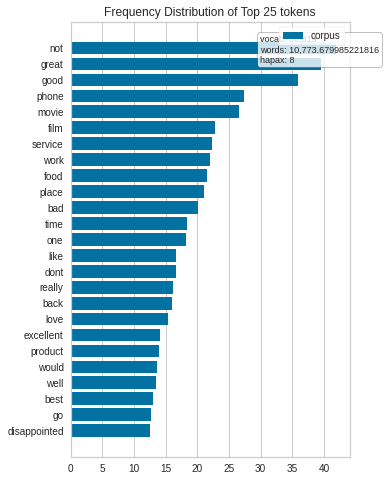

In [ ]:
#What is valuable to see with this visualization is that after all the preprocessing work, the top tokens are words that will drive polarity like 'not', 'great', and 'good'. 
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(5,8))
visualizer = FreqDistVisualizer(features=vectorizer.get_feature_names(), n=25)
visualizer.fit(concat_transformed)
visualizer.poof()

### Part 1.b. Modeling

Use your favorite ML algorithm to train a classification model.  Don’t forget everything that we’ve learned in our ML course: hyperparameter tuning, cross validation, handling imbalanced data, etc. Make reasonable decisions and try to create the best-performing classifier that you can.

#### Random Forest
Below, I will be applying stratified k-fold cross validation and the respective grid searches for hyper parameter tuning on Random Forest, KNN, Decision Trees, and SVM. As mentioned earlier, there didn't appear to be a data imbalance so I did not need to revisit the train and test splits for any type of sampling measures (oversampling, undersampling, SMOTE, etc.). 

In [ ]:
# Grid Search Parameters for RandomForest
param_grid = {'max_depth': [5, 8, 30],
 'min_samples_leaf': [1, 2, 10],
 'min_samples_split': [2, 5, 100],
 'n_estimators': [100, 300, 1200]}

# Training config
kfold = StratifiedKFold(n_splits=7)
scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

# Perform GridSearch
rf_model = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=kfold, scoring=scoring, 
                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
rf_model.fit(train_transformed, x_val)

Fitting 7 folds for each of 81 candidates, totalling 567 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 567 out of 567 | elapsed: 21.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
#Review best parameters, score, and estimator
rf_model.best_params_
print('\n')
rf_model.best_score_
print('\n')
rf_model.best_estimator_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 100,
 'n_estimators': 1200}

0.8074295231655159

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### KNN

In [ ]:
param_grid = {'weights': ('uniform', 'distance'), 
              'n_neighbors': [3,5,11,19], 
              'metric': ['euclidean', 'manhattan']}

knn_model = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=kfold, scoring=scoring, 
                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
knn_model.fit(train_transformed, x_val)

Fitting 7 folds for each of 16 candidates, totalling 112 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   48.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ('uniform', 'distance')},
             pre_dispatch='2*n_jobs', refit='F1', return_train_score=True,
             scoring={'Accuracy': 'accuracy', 'F1': 'f1_macro'}, verbose=1)

In [ ]:
#Review best parameters, score, and estimator
knn_model.best_params_
print('\n')
knn_model.best_score_
print('\n')
knn_model.best_estimator_

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}

0.8061859858716994

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

#### Decision Tree

In [ ]:
param_grid = {'criterion': ('gini', 'entropy'), 
              'max_depth': [2, 10, 20], 
              'min_samples_leaf': [1, 5, 10],
              'max_leaf_nodes':[None, 10, 50]}

dt_model = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=kfold, scoring=scoring, 
                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
dt_model.fit(train_transformed, x_val)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 7 folds for each of 54 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:  1.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
       

In [ ]:
#Review best parameters, score, and estimator
dt_model.best_params_
print('\n')
dt_model.best_score_
print('\n')
dt_model.best_estimator_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1}

0.804560821227173

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### Support Vector Machine

In [ ]:
param_grid = {'C': [0.1,0.01,0.025], 
          'gamma': [1,0.1,0.01,0.02, 0.001],
          'kernel': ['rbf', 'sigmoid','linear']}

svm_model = GridSearchCV(SVC(), param_grid=param_grid, cv=kfold, scoring=scoring, 
                         refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
svm_model.fit(train_transformed, x_val)

Fitting 7 folds for each of 45 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:  3.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 0.01, 0.025],
                         'gamma': [1, 0.1, 0.01, 0.02, 0.001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             pre_dispatch='2*n_jobs', refit='F1', return_train_score=True,
             scoring={'Accuracy': 'accuracy', 'F1': 'f1_macro'}, verbose=1)

In [ ]:
#Review best parameters, score, and estimator
svm_model.best_params_
print('\n')
svm_model.best_score_
print('\n')
svm_model.best_estimator_

{'C': 0.025, 'gamma': 0.02, 'kernel': 'rbf'}

0.7959267705290806

SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.02, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Updated Models: Random Forest & KNN
After applying hyperparameter tuning, it appears that random forest classifier and KNN nets the best F1 scores out of the aforementioned models. We'll assess RF and KNN to see which one nets a better score on the test data.

In [ ]:
rf_tuned = RandomForestClassifier(max_depth= 5,
                                  min_samples_leaf= 1,
                                  min_samples_split= 5,
                                  n_estimators= 300)
rf_tuned.fit(train_transformed, x_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
knn_tuned = KNeighborsClassifier(metric = 'euclidean', 
                                  n_neighbors = 3, 
                                  weights = 'uniform')
knn_tuned.fit(train_transformed, x_val)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

### Part 1.c. Assessing

Use the testing data to measure the accuracy and F1-score of your model.  

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score

pred_val = rf_tuned.predict(test_transformed)

print("Confusion matrix:")
print(confusion_matrix(y_val, pred_val))

print("\nAccuracy = {:.5f}".format(accuracy_score(y_val, pred_val)))

print("\nF1 Score = {:.5f}".format(f1_score(y_val, pred_val)))

print("\nClassification Report:")
print(classification_report(y_val, pred_val))

Confusion matrix:
[[241  46]
 [ 94 219]]

Accuracy = 0.76667

F1 Score = 0.75779

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       287
           1       0.83      0.70      0.76       313

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.78      0.77      0.77       600



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score, accuracy_score

pred_val = knn_tuned.predict(test_transformed)

print("Confusion matrix:")
print(confusion_matrix(y_val, pred_val))

print("\nAccuracy = {:.5f}".format(accuracy_score(y_val, pred_val)))

print("\nF1 Score = {:.5f}".format(f1_score(y_val, pred_val)))

print("\nClassification Report:")
print(classification_report(y_val, pred_val))

Confusion matrix:
[[234  53]
 [ 91 222]]

Accuracy = 0.76000

F1 Score = 0.75510

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.76       287
           1       0.81      0.71      0.76       313

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.77      0.76      0.76       600



#### Conclusion: The tuned random forest model netted the best accuracy and F1 score.

### Dig into root cause of classification issues.

In [ ]:
#Combine predictions with actual polarity values and filter for false positives and false negatives
final_review = df_2
final_review['Predicted Values'] = pred_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence,Polarity,Sentence_clean,Lexicon-based Polarity Calc,Lexicon-based Subjectivity Calc,Lexicon-based Polarity Dummy Calc,Predicted Values
0,A good commentary of today's love and undoubte...,1,good commentary today love undoubtedly film wo...,0.500000,0.433333,1,1
1,For people who are first timers in film making...,1,people first timer film making think excellent...,0.625000,0.666667,1,1
2,"It was very popular when I was in the cinema, ...",1,popular cinema good house good reaction plenty...,0.575000,0.550000,1,1
3,It's a feel-good film and that's how I felt wh...,1,feel good film thats felt came cinema,0.700000,0.600000,1,1
4,It has northern humour and positive about the ...,1,northern humour positive community represents,0.227273,0.545455,1,1


In [ ]:
filtered_review = final_review.loc[final_review['Polarity'] != final_review['Predicted Values']]

In [ ]:
pd.set_option('display.max_colwidth', None)
filtered_review.head(20)

,Sentence,Polarity,Sentence_clean,Lexicon-based Polarity Calc,Lexicon-based Subjectivity Calc,Lexicon-based Polarity Dummy Calc,Predicted Values
12,Not too screamy not to masculine but just right.,1,not scream not masculine right,0.117857,0.417857,1,0
15,"As a European, the movie is a nice throwback to my time as a student in the 1980's and the experiences I had living abroad and interacting with other nationalities, although the circumstances were slightly different.",1,european movie nice throwback time student experience living abroad interacting nationality although circumstance slightly different,0.200000,0.533333,1,0
21,"This movie is excellent!Angel is beautiful and Scamp is adorable!His little yelps when hes scared,and the funniest parts are when:Scamp is caught under the curtain and when Angel and Scamp are singing 'Ive Never Had This Feeling Before'.I totally recommend this movie,its coming out on special edition on June 20.The cover has scamp on a garbage can and Angel underneath the lid.",1,movie excellentangel beautiful camp adorablehis little help he scaredand funniest part whenscamp caught curtain angel camp singing ive never feeling totally recommend movie coming special edition june cover camp garbage angel underneath lid,0.254911,0.705357,1,0
33,It came free with a DVD player I bought but I still turned the thing off halfway through because I was embarrassed for Howell.,0,came free dvd player bought still turned thing halfway embarrassed powell,0.400000,0.800000,1,1
36,"The soundtrack wasn't terrible, either.",1,soundtrack wasnt terrible either,-1.000000,1.000000,0,0
38,"Still, it was the SETS that got a big ""10"" on my ""oy-vey"" scale.",1,still set got big scale,0.000000,0.100000,0,0
43,The last 15 minutes of movie are also not bad as well.,1,last minute movie also not bad well,0.175000,0.366667,1,0
48,My 8/10 score is mostly for the plot.,1,score mostly plot,0.500000,0.500000,1,0
51,"Not frightening in the least, and barely comprehensible.",0,not frightening least barely comprehensible,0.116667,0.700000,1,1
53,Not even good for camp value!,0,not even good camp value,0.700000,0.600000,1,1


####The following are 5 examples that were predicted incorrectly:
1. "**See it.**", Predicted=0, Actual=1, (index=93)
2. "**My 8/10 score is mostly for the plot.**", Predicted=0, Actual=1, (index=48)
3. "**Still, it was the SETS that got a big "10" on my "oy-vey" scale.**", Predicted=0, Actual=1, (index=38)
4. "**Lifetime does not air it enough, so if anyone knows what store sells it let me know because this is a must-have.**", Predicted=0, Actual=1, (index=87)
5. "**This movie is excellent!Angel is beautiful and Scamp is adorable!His little yelps when hes scared,and the funniest parts are when:Scamp is caught under the curtain and when Angel and Scamp are singing 'Ive Never Had This Feeling Before'.I totally recommend this movie,its coming out on special edition on June 20.The cover has scamp on a garbage can and Angel underneath the lid.**", Predicted=0, Actual=1, (index=21)




**Example 1** demonstrates a one-off error and how tricky language is due to meaning and quality. 'See it' is ambiguously describing a command to watch a film with a subtle inference that it worth watching. This is extremely challenging to capture in sentiment analysis and is also a rare example of a review.

**Example 2** demonstrates a systematic modelling weakness. Despite a '8/10 score' denoting positive sentiment, the preprocessing was set up to remove punctuation and numbers. It is also difficult to build this interpretation into the preprocessing as it could be described in a number of different ways, from '8 out of 10' to 'eight out of ten'. Furthermore, there could be a different scale such as 'two thumbs up' or 'five stars'. Therefore, this example is also demonstrating the challenges of meaning and quality in the human language. 

**Example 3** demonstrates another systematic modelling weakness. Similarly the 'big 10' infers a positive sentiment, but the preprocessing is currently set up to remove numbers. The other piece of this review is the 'oy-vey' scale. On one hand, 'oy-vey' is slang in the form of a Yiddish phrase that originally expressed grief. However, it appears to infer a positive result here. Furthermore, the original author placed punctuation all around the comment, which would break it up into 'oy' and 'vey' before getting completely removed during preprocessing.

**Example 4** demonstrates additional difficulties with the human language. The beginning relates to some out-of-context information about Lifetime, an American cable channel, not airing the film enough. It would be challenging to understand the polarity of this statement with sentiment analysis and is an example of a one-off error. The modelling weakness comes with the phrase 'must-have' being concatenated into 'musthave' after punctuation was removed. It could be argued that the preprocessing should be tweaked to capture 'must-have' as a positive sentiment phrase.

**Example 5** demonstrates systematic modelling weakness that plagues the results of this existing model. There appear to be various authors throughout the dataset that do not space the review appropriately. While not included in this specific example, this regularly took the form of joining sentences with '...' or other punctuation. The existing preprocessing would remove the punctuation characters thereby joining words together to the point that the spellcheck could not differentiate the two joined words. Therefore, it would be worth exploring a step to replace the punctuation with a space character and then after removing any leading or trailing space characters to adjust for this occurrence.